<p style="text-align: center;font-size: 40pt">Point cloud association</p>

In [1]:
%matplotlib inline

import matplotlib.pyplot as plt
import numpy as np
from scipy import spatial
from IPython.display import HTML

%run ./scripts/helper_func.py
path = "{0}/lessons/transformations_2d/scripts/helper_func.py".format(get_root_path())
%run $path
path = "{0}/common/scripts/style.py".format(get_root_path())
%run $path

# Overview 

Requirements
- [Overview of registration algorithms](1-lesson_overview.ipynb)

Objectives of this lesson:
- explain the basic concept of point cloud association
- give details about possible implementation optimizations

Hidden custom latex commands here $ \curvearrowright$

----
[comment]: <> (General commands)
$\DeclareMathOperator*{\argmin}{arg\,min}$
$\DeclareMathOperator{\error}{error}$
$\DeclareMathOperator*{\match}{match}$
$\DeclareMathOperator{\distance}{d}$
$\DeclareMathOperator{\outlier}{outlier}$
$\DeclareMathOperator{\weight}{w}$
$\DeclareMathOperator{\datafilter}{datafilter}$
$\newcommand{\mat}[1]{\mathbf{#1}}$
$\newcommand{\point}[2][]{{}^{#1}\mathbf{#2}}$
$\newcommand{\frame}[1]{\mathcal{#1}}$
$\newcommand{\shape}[2][]{{}^{#1}\mathcal{#2}}$
$\newcommand{\matches}[1]{\mathcal{#1}}$
$\newcommand{\transformation}[3][T]{{}_{#2}^{#3}\mat{#1}}$
$\newcommand{\weights}[1]{\mathcal{#1}}$
$\newcommand{\textcomma}{\quad,}$
$\newcommand{\textdot}{\quad.}$
----

# Introduction
As explained in [the overview of registration algorithms](1-lesson_overview.ipynb#Algorithm-Overview), points from <tt>reading</tt> and <tt>reference</tt> have to be associated into pairs that will be the basis of the computation of the error to be minimized.
The association solver (called also *match function*) then yields a set of pairs of points:

$$
    \matches{M}=\match(\shape{P}, \shape{Q})=\left\{(\point{p}, \point{q}): \point{p}\in\shape{P}, \point{q}\in\shape{Q}\right\}
$$

# Types of association
The association of the <tt>reading</tt> with the <tt>reference</tt> can be divided into three types: 

1. feature matching, 
2. descriptor matching, and 
3. mixed.

Feature matching is mainly done using Euclidean distance between a point in the <tt>reference</tt> and a point in the <tt>reading</tt> [\[Pulli, 1999](https://ieeexplore.ieee.org/document/805346), [Druon et al.,2006](https://ieeexplore.ieee.org/document/4097937), [Censi, 2008](https://ieeexplore.ieee.org/document/4543181), [Segal et al., 2009](http://www.roboticsproceedings.org/rss05/p21.html), [Pan et al., 2010](https://ieeexplore.ieee.org/document/5476132), [Kim, 2010\]](https://ieeexplore.ieee.org/document/5373827), a point and a plane [[Champleboux et al., 1992]](https://ieeexplore.ieee.org/document/223223) and quadrics [[Feldmar and Ayache, 1994]](https://ieeexplore.ieee.org/document/323872).
Custom distances based on point positions and angles is also used [[Armesto et al., 2010]](https://ieeexplore.ieee.org/document/5509371).
Descriptors are also matched based on their Euclidean distances [\[Lowe, 2004](https://link.springer.com/article/10.1023%2FB%3AVISI.0000029664.99615.94), [Bosse and Zlot, 2009b\]](https://ieeexplore.ieee.org/document/5152851).
The concept of measuring distance between two entities can take multiple forms (e.g., correlation matching, earth mover distance, $L^1$, $L^{inf}$).
In the current literature reviewed, other distances used in matching functions were Mahalanobis [[Stewart et al., 2003]](https://ieeexplore.ieee.org/document/1242341) and $\chi^2$-test statistic [[Tsai et al., 2010]](https://ieeexplore.ieee.org/document/5223602).
Using only features or descriptors in the association have their advantages and inconveniences.
In lidar based matching, feature positions are quite accurate compared to descriptor uniqueness, but the <tt>initial transformation</tt> needs to be within a maximum range to avoid local minima. 
When using descriptors, the matching becomes independent of the initial position, but may fail for repetitive elements (e.g., checkerboard, building facades with repetitive windows). 

A logical extension is to mix both types of matching. 
One way is to express descriptors in the feature space using a conversion factor. 
This method was used to combine point distances with surface orientations [\[Jost and Hügli, 2002](https://link.springer.com/chapter/10.1007/3-540-45783-6_12), [Bosse and
Zlot, 2009b\]](https://ieeexplore.ieee.org/document/5152851), surface orientations and color [[Schutz et al., 1998]](https://ieeexplore.ieee.org/document/711852), color [[Johnson and Kang, 1997]](https://ieeexplore.ieee.org/document/603871) and laser intensity [\[Godin et al., 1994](https://www.spiedigitallibrary.org/conference-proceedings-of-spie/2350/1/Three-dimensional-registration-using-range-and-intensity-information/10.1117/12.189139.short), [Yoshitaka et al., 2006\]](https://ieeexplore.ieee.org/document/4153430). 
The other way around is also possible (i.e., expressing feature positions in descriptor space). 
In [[Mortensen et al., 2005]](https://ieeexplore.ieee.org/document/1467266), a descriptor, called Global Context, is created using surrounding feature positions. 
The distance is computed as the sum of the Euclidean distance of a Scale Invariant Feature Transform (SIFT) descriptor with the $\chi^2$ distance of the Global Context descriptor.
A ratio between feature and descriptor distances is required to join the different spaces together, but it is often implicitly defined as unity [[Tsai et al., 2010]](https://ieeexplore.ieee.org/document/5223602). 


Other parameters to consider during the matching stage are the match direction and the number of matches used. 
The match direction refers to either match from the <tt>reference</tt> to the <tt>reading</tt> or from the <tt>reading</tt> to the <tt>reference</tt>.
Most of the time, one of those two possibilities is used without further consideration, but some techniques use both directions [\[Pulli, 1999](https://ieeexplore.ieee.org/document/805346), [Godin et al., 1994\]](https://www.spiedigitallibrary.org/conference-proceedings-of-spie/2350/1/Three-dimensional-registration-using-range-and-intensity-information/10.1117/12.189139.short).
As for the number of matches, most of the applications consider only the closest point but some others process a certain percentage of the lowest distance [[Stewart
et al., 2003]](https://ieeexplore.ieee.org/document/1242341) or the complete matching matrix. 
The complete matching matrix is often used in loop closing detection [[Bosse and Zlot, 2009a]](https://www.sciencedirect.com/science/article/abs/pii/S0921889009000992) but it can be used for local matching, as with the SoftAssign method [\[Gold et al., 1998](https://www.sciencedirect.com/science/article/abs/pii/S0031320398800101), [Liu, 2010\]](https://ieeexplore.ieee.org/document/5291420).

# Implementation optimization
The association solver deals with the Nearest Neighbor (NN) problem, which typically has a complexity of $O(nm)$ where $n$ and $m$ are respectively the number of elements in the <tt>reading</tt> and in the <tt>reference</tt>.
This stage is generally the most time-consuming and a lot of papers present variations of NN search to reduce its complexity. 
A dynamic space partitioning can by applied using [kD-trees](https://en.wikipedia.org/wiki/K-d_tree) to reduce the search complexity to $O(n\log{m})$ after a $O(m\log{m})$ building phase.
Approximate kD-trees decreases the computational time by employing a distance threshold to limit the search at the risk of returning sub-optimal neighbors [[Arya and Mount, 1993]](https://dl.acm.org/doi/abs/10.5555/313559.313768). 
This increases the overall speed of the search, while the redundancy between points prevents large accuracy degradation [[Nüchter et al., 2005]](https://ieeexplore.ieee.org/document/1507419).
In an iterative context, [Nüchter et al. [2007]](https://ieeexplore.ieee.org/document/4296783) propose to use cached kD-tree for faster search.
NN from the previous iteration are feed to the current search as starting points to accelerate the computation.
Additionally, [Zlot and Bosse [2009]](https://link.springer.com/chapter/10.1007/978-3-642-00196-3_42) compare kD-tree, locality-sensitive hashing and spill-trees and concluded that the kD-tree is better in terms of accuracy, query time, build time, and memory usage. 
They also observed that approximations can reduce the query time by two orders of magnitude while maintaining sufficient accuracy.

KD-trees provide very little acceleration for high dimension vectors like the ones used for image based descriptors.
Static space partitioning, usually based on grid or hashing, offer less adaptation but can compensate with their computation speed.
Approximate search based on [Best-Bin-First](https://en.wikipedia.org/wiki/Best_bin_first) can be used instead for optimization [[Lowe, 2004]](https://link.springer.com/article/10.1023%2FB%3AVISI.0000029664.99615.94).
Other techniques use a dual proximity hypothesis (e.g., laser points ordered by a temporal sequence [[Censi, 2008]](https://ieeexplore.ieee.org/document/4543181), n-search [[Jost and Hugli, 2002]](https://ieeexplore.ieee.org/document/1024114)), projection on one grid [[Pan et al., 2010]](https://ieeexplore.ieee.org/document/5476132) or on multiple grid (called multi Z-buffer) [[Benjemaa and Schmitt, 1997]](https://ieeexplore.ieee.org/document/603856) to also reduce the search time.
Although very useful, kD-tree also limits the distance metric used to be Euclidean.
This forces some approximations when using Euclidean distances between components of unit surface normal vectors instead of the angle between them [\[Feldmar and Ayache, 1996](https://link.springer.com/article/10.1007/BF00054998), [Eggert et al., 1998](https://www.sciencedirect.com/science/article/abs/pii/S1077314298906671), [Gelfand et al., 2003\]](https://ieeexplore.ieee.org/document/1240258).
[Figure 2.5](#errorNormalDistance) illustrates the error between the angle distance of surface normal vectors against the approximation using Euclidean distance.
One can notice that, as long as the distance is low, the approximation can hold but, with large error the approximation is much less accurate.
Moreover, the construction of the tree requires some time, and often only the <tt>reference</tt> is used as seeding points.
Limiting the number of kD-tree constructions by the use of keyframes or metascans can help to decrease the registration time for a sequence of scans, while limiting the drift of the final path [[Wulf et al., 2008]](https://onlinelibrary.wiley.com/doi/10.1002/rob.20234).
<p id="errorNormalDistance" style="text-align: center;">
    <img src="images/fig2_5.png" width="50%"/> <br/>
    <b>Figure 2.5:</b> Impact of using Euclidean distance instead of angle between surface normal vectors.
    Impact of using Euclidean distance (solid blue line) instead of angle (dashed yellow line) between surface normal vectors.
    The shaded gray area represents the error.
</p>

Cascade systems, is also another research direction to accelerate the search.
[Jost and Hugli [2003]](https://ieeexplore.ieee.org/document/1240278) compute Iterative Closest Point (ICP) several times while varying the resolution from coarse to fine. 
At a coarse resolution (i.e., with a limited number of points) ICP converges faster but with less accuracy than at a fine resolution.
However, by initializing a finer-resolution ICP with the result of the coarser one, the convergence of the fine-resolution ICP is much faster than with a single-shot ICP, as the initial alignment is mostly correct.
These authors also used a pre-computed list of NN to approximate the matching step.
With both of these techniques, they showed a significant increase of the speed of ICP while maintaining adequate robustness.
For the same absolute performance as standard ICP, [Li et al. [2010]](https://ieeexplore.ieee.org/abstract/document/5659287) use fewer iterations at high resolution, which decreases the total time by a factor of 1.5 in 2D and 2.5 in 3D.
The multi-resolution approach can also increase the search speed for the closest point by using a hierarchical-model point selection with a stereo camera [[Kim, 2010]](https://ieeexplore.ieee.org/document/5373827).
By subsampling the space and with the help of the sensor structure, this solution can achieve a speed gain of factor 3 with respect to standard ICP when using a kD-tree search.
In this case, the use of the structure of the depth image increases the matching speed.
In the same direction, the specificity of a 2D laser scanner acquisition structure can help optimize the search [[Censi, 2008]](https://ieeexplore.ieee.org/document/4543181).
However, these optimizations are oriented toward specific sensors, which makes them hard to generalize, and are not suitable for a multi-sensor setup.

## Example

When only one match is kept from the <tt>reading</tt> $\shape{P}$ to the <tt>reference</tt> $\shape{Q}$ based on the Euclidean distance, the association is defined as:
$$
    \matches{M}=\match(\shape{P}, \shape{Q})=
    \left\{\left(\point{p}_n, \point{q}_m\right) : \forall \point{p}_n \in \shape{P}, \point{q}_m = \argmin_j \big(\distance(\point{p}_n, \point{q}_j)\big)\right\}
$$
with $\distance(\point{p}, \point{q})=\|\point{p}-\point{q}\|_2$, the Euclidean distance.
We can do a code example of finding one nearest neighbor in $\shape{Q}$ for each point in $\shape{P}$ manually.

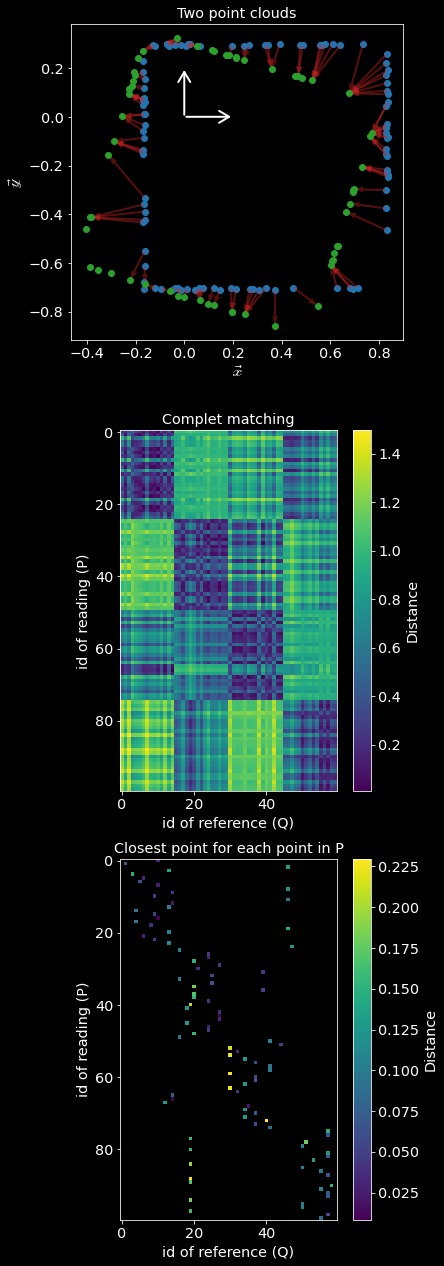

In [2]:
# Generate two point clouds
# TODO: change the parameter nb_pts to 1000
P = build_room([1.2, 2.], [2.2, 1.5], angle=-0, nb_pts=100)[:2]
Q = build_room([1.8, 2.], [2.8, 2.2], angle=-0.3, nb_pts=60)[:2]

nb_pts_p = P.shape[1]
nb_pts_q = Q.shape[1]

# prepare data storage
dist_mat = np.zeros([nb_pts_p, nb_pts_q])
min_dist_mat = np.empty_like(dist_mat)
min_dist_mat[:] = np.NaN
match = np.empty(nb_pts_p, dtype=int)

# compute the distance between all points
for i,p in enumerate(P[:2].T):
    for j,q in enumerate(Q[:2].T):
        dist_mat[i,j] = np.linalg.norm(p - q)

# keep the smallest distance for each point in P
for i,p_dists in enumerate(dist_mat):
    min_id = np.argmin(p_dists)
    match[i] = min_id
    min_dist_mat[i,min_id] = dist_mat[i,min_id]

# compute the error to the shortest point (for display)
# match is the set M in the text
errors = Q[:,match] - P

# -----------------------
# plotting
fig, axs = plt.subplots(nrows=3, ncols=1, figsize=(6,18))

ax=axs[0]
draw_point_clouds(ax, P=P, Q=Q, errors=errors, alpha=1.)
ax.set_title("Two point clouds")

ax=axs[1]
cmap = ax.imshow(dist_mat)
cbar = fig.colorbar(cmap, ax=ax)
cbar.set_label('Distance')
ax.set_title("Complet matching")
ax.set_xlabel("id of reference (Q)")
ax.set_ylabel("id of reading (P)")

ax=axs[2]
cmap = ax.imshow(min_dist_mat)
cbar = fig.colorbar(cmap, ax=ax)
cbar.set_label('Distance')
ax.set_title("Closest point for each point in P")
ax.set_xlabel("id of reference (Q)")
ax.set_ylabel("id of reading (P)")

fig.tight_layout()

You can observe that not all points in $\shape{Q}$ will be used to define the alignment error.
We can do the same computation using a kd-tree.
You should be able to feel the computation time difference once you try to generate point cloud with `nb_pts` set to more than 1000 points in the code cell above.

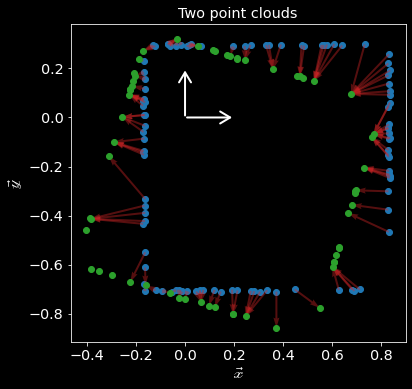

In [3]:
tree = spatial.KDTree(Q.T)
dist, match = tree.query(P.T, k=1)

errors = Q[:,match] - P

# -----------------------
# plotting
fig, ax = plt.subplots(nrows=1, ncols=1, figsize=(6,6))

draw_point_clouds(ax, P=P, Q=Q, errors=errors, alpha=1.)
ax.set_title("Two point clouds");

# Conclusion
You should do the following activities to enhance your understanding of the concepts viewed in this lesson:
- modify the markdown by adding your own notes using `> my notes`; and
- complete the tables [Symbol definitions](#Symbol-definitions) and [Glossary](#Glossary) and add your own definitions.

Next lesson:
- [Outliers](3-lesson_outliers.ipynb)

## Symbol definitions

| &nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp; Symbol &nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp; | Definition                    |
|:--------------------------------:|:-----------------------------------------------------:|
| $\match(\shape{P}, \shape{Q}) $  | Set of matches between $\shape{P}$ and $\shape{Q}$    |
| $\distance(\point{p}, \point{q})$| Distance between points $\point{p}$ and $\point{q}$   |

## Glossary

| English   | Français   | Definition |
|-----------|------------|------------|
|           |            |            |